In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
#import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=15, processes=15, walltime='04:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.39:8787/status,
Dashboard: http://10.148.0.39:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.39:36773,Workers: 0
Dashboard: http://10.148.0.39:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Import data

In [4]:
i=4
l=labels[i]

#OPEN DATA FILES
ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr').persist()
ds_stress= xr.open_zarr(zarr_dir+'/erastar/erastar_'+l+'.zarr').persist()# TO CHANGE ONCE GOOD FILES GENERATED
ds_corr = xr.open_zarr(zarr_dir+'/slacorrection_'+l+'.zarr').persist()
ds_aviso = xr.open_zarr(zarr_dir+'/aviso_'+l+'.zarr').persist()                                                    

In [16]:
def combinations(_ds):
    """ Create a list of dictionnaries containing the different data combinations possible to rebuild the moment conservation
    
    Parameters
    ----------
    _ds: dataset
        contains - drifter_acc_x/y, 
                 - drifter_coriolisx/y, 
                 - sla gradients from the different sources all fiishing with '_g_grad_x/y',
                 - wind terms from the different sources and way to compute it from stress all finishing with '_wd_x/y'
    Returns
    ----------
    [{'acc': 'drifter_acc_x','coriolis': 'drifter_coriolis_x','ggrad': 'alti_g_grad_x','wind': 'es_cstrio_z0_alti_wd_x','id': 'co_es_cstrio_z0_alti_x'},....] 
    list of dictionnaries containing the varaibles taken for each term and an identification: gradsrc_wdsrc_wdmethod_wddepth_matchupposition_x/y
    """
    wd_x=[l for l in _ds if 'wd_x' in l]
    wd_y=[l for l in _ds if 'wd_y' in l]
    grad_x = [l for l in _ds if 'g_grad_x' in l]
    grad_y = [l for l in _ds if 'g_grad_y' in l]
    acc_cor_x = ['drifter_acc_x','drifter_coriolis_x']
    acc_cor_y = ['drifter_acc_y','drifter_coriolis_y']
    
    LIST =[]
    
    for grad in grad_x:
        for wd in wd_x :
            lx={'acc':'drifter_acc_x', 'coriolis':'drifter_coriolis_x', 'ggrad':'', 'wind':'', 'id':''}   
            #AVISO grad
            if 'aviso' in grad:#
                if (('alti' in grad) and ('alti' in wd)) :
                    lx['ggrad'] =grad
                    lx['wind'] = wd
                    lx['id'] = grad.replace('alti_', '').replace('g_grad_x', '')+'_'.join(wd.split('_')[:3])+'_alti_x'
                    LIST.append(lx)
                elif (('drifter' in grad) and ('drifter' in wd)) : 
                    lx['ggrad']=grad
                    lx['wind']= wd
                    lx['id'] = grad.replace('drifter_', '').replace('g_grad_x', '')+'_'.join(wd.split('_')[:3])+'_drifter_x'
                    LIST.append(lx)
            #Altimeters' grad
            elif 'alti' in grad : 
                if 'alti' in wd:
                    lx['ggrad']=grad
                    lx['wind'] = wd
                    lx['id'] = 'co_'+grad.replace('alti_', '').replace('g_grad_x', '')+'_'.join(wd.split('_')[:3])+'_alti_x'
                    LIST.append(lx)
                elif 'drifter' in wd : 
                    lx['ggrad']=grad
                    lx['wind']=wd
                    lx['id'] = 'co_'+grad.replace('alti_', '').replace('g_grad_x', '')+'_'.join(wd.split('_')[:3])+'_drifter_x'
                    LIST.append(lx)
                    
    for grad in grad_y:
        for wd in wd_y :
            ly={'acc':'drifter_acc_y', 'coriolis':'drifter_coriolis_y', 'ggrad':'', 'wind':'', 'id':''}
            
            if (('alti' in grad) and ('alti' in wd)) :
                ly['ggrad'] = grad
                ly['wind'] = wd
                ly['id'] = '_'.join(grad.split('_')[:1])+'_'+'_'.join(wd.split('_')[:3])+'_alti_y'
                LIST.append(ly)
            
            elif(('drifter' in grad) and ('drifter' in wd)) :
                ly['ggrad']= grad
                ly['wind'] = wd
                ly['id'] = '_'.join(grad.split('_')[:1])+'_'+'_'.join(wd.split('_')[:3])+'_drifter_y'
                LIST.append(ly)
    return LIST


_data_var = ['f','box_theta_lon','__site_matchup_indice','box_theta_lat','drifter_theta_lon', 'drifter_theta_lat', 'alti___distance','alti___time_difference',
             'alti_g_grad_x','alti_denoised_g_grad_x', 'drifter_acc_x', 'drifter_acc_y', 'drifter_coriolis_x', 'drifter_coriolis_y']
_aviso_var = ['aviso_alti_matchup_g_grad_x', 'aviso_alti_matchup_g_grad_y',
              'aviso_drifter_matchup_g_grad_x','aviso_drifter_matchup_g_grad_y',
              'aviso_alti_matchup_adt_g_grad_x', 'aviso_alti_matchup_adt_g_grad_y',
              'aviso_drifter_matchup_adt_g_grad_x','aviso_drifter_matchup_adt_g_grad_y']
_stress_var = ['e5_alti_matchup_taue','e5_alti_matchup_taun','es_alti_matchup_taue', 'es_alti_matchup_taun',
             'e5_drifter_matchup_taue','e5_drifter_matchup_taun','es_drifter_matchup_taue', 'es_drifter_matchup_taun',]
_corr_var = ['alti_adt_g_grad_x', 'alti_adt_oceantide_g_grad_x','alti_adt_oceantide_dac_g_grad_x']


list_wd_srce_suffix = ['es', 'e5']
list_func = [stw.cst_rio_z0, stw.cst_rio_z15]
list_func_suffix = ['cstrio_z0', 'cstrio_z15']



def datasets_for_pdfs(ds_data, ds_aviso, ds_stress,ds_corr,sum_ = False, except_ = False, cross_ = False,
                      _data_var = _data_var, _aviso_var = _aviso_var, _stress_var = _stress_var, _corr_var=_corr_var,
                      list_wd_srce_suffix = list_wd_srce_suffix, list_func = list_func, list_func_suffix = list_func_suffix, east_north=False
                     ):
    """ Create a list of dictionnaries containing the different data combinations possible to rebuild the moment conservation
    
    Parameters
    ----------
    ds_data: dataset 
            dataset containing colocalisations, should contain at least the _data_var
    ds_aviso: dataset
            dataset containing aviso sla gradient terms
    ds_stress:dataset
            dataset containing wind stress that will be used to compute the wind stress divergence term
    ds_corr: dataset
            dataset containing sla gradient with corrections terms, default is adt and adt+tide
    sum_: bool
            if true create a dataset with sum values of all the different combinations found with the combination function
    except_: bool
            if true create a dataset with sum values except one term for all the different combinations found with the combination function
    _data_var: str list
            list of variables to extract from ds_data, should contains at least ['f','box_theta_lon','__site_matchup_indice','box_theta_lat','drifter_theta_lon', 'drifter_theta_lat', 'alti___distance','alti___time_difference','drifter_acc_x', 'drifter_acc_y', 'drifter_coriolis_x', 'drifter_coriolis_y']
    _aviso_var: str list 
            list of variables to extract from ds_aviso
    _stress_var: str list 
            list of variables to extract from ds_stress
    _corr_var: str list 
            list of variables to extract from ds_corr
    list_wd_srce_suffix : str list
            list of wind stress term source suffix, ex : if we want only erastar wind stress list_wd_srce_suffix= ['es'], default is all sources
    list_func : function list
            list of functions to compute wind term from wind stress, these functions have to take the functions in the stress_to_windterm.py library as a model
    list_func_suffix : str list
            suffix to put in wind term variable name to identify the function used to compute wind term from wind stress, should correspond to list_func

    """
    #CHOOSE INTERESTING DATA
    _ds_data = ds_data.isel(site_obs = ds_data.__site_matchup_indice.compute(), alti_time_mid=10)[_data_var].drop(['alti_time_mid','alti_x_mid','alti_y_mid'])
    _ds_aviso = ds_aviso[_aviso_var]
    _ds_stress = ds_stress[_stress_var]
    _ds_corr = ds_corr[_corr_var].isel(alti_time_mid=10).drop('alti_time_mid')
    
    
    #FOR IND PDFS
    _ds = xr.merge([_ds_data, _ds_aviso, _ds_stress, _ds_corr])
    
    #COMPUTE WD TERM
    _ds = xr.merge([_ds,stw.compute_wd_from_stress(_ds,list_wd_srce_suffix,list_func, list_func_suffix, east_north )])
    
    _ds = _ds.drop(_stress_var+['f','box_theta_lon', 'box_theta_lat','drifter_theta_lon', 'drifter_theta_lat','__site_matchup_indice']).set_coords(['alti___distance','alti___time_difference'])
    _ds = _ds.rename({v: v.replace("_matchup", "") for v in _ds})
    
    #SUM combination
    COMB = combinations(_ds)
     
    _ds_sum = xr.Dataset() 
    _ds_except = xr.Dataset() 
    _ds_cross = xr.Dataset()
    
    id_comb_list = []
    for comb in COMB :
        _id = comb['id']
        id_comb_list.append(_id)
        comb.pop('id')
        _ds['id_comb']= id_comb_list
        
        if sum_ :
            #TOTAL SUM
            S=0
            for l in list(comb.values()):
                S= S + _ds[l]
            id_str = 'sum_'+_id
            _ds_sum[id_str] = xr.DataArray(data=S, attrs={'description' : '+'.join(comb.keys()),
                                                          'long_name':'+'.join([_ds[comb[v]].attrs['long_name'] for v in comb.keys()]),
                                                          'units':r'$m.s^{-2}$',
                                                          **comb})
            _ds_sum['id_comb']= id_comb_list
            
        if except_ :
            #EXCEPT ONE
            for except_key in list(comb.keys()):
                id_str_2 ='exc_'+except_key+'_'+_id
                S2=0
                keys = [l for l in comb.keys() if l!=except_key]
                for key in keys :
                    if key!= except_key :
                        S2= S2 +_ds[comb[key]]
                _ds_except[id_str_2] = xr.DataArray(data=S2, attrs={'description' : '+'.join(keys),
                                                          'long_name':'+'.join([_ds[comb[v]].attrs['long_name'] for v in keys]),
                                                          'units':r'$m.s^{-2}$',
                                                          **comb})
                _ds_except['id_comb']= id_comb_list
        if cross_:
            #correlation terms
            keys = list(comb.keys())
            for i in range(len(keys)-1):
                key1=keys[i]
                for key2 in keys[i+1:]:
                    if key2!=[]:
                        id_str_3='cro_'+key1+key2+'_'+_id
                        S3=_ds[comb[key1]]*_ds[comb[key2]]
                        _ds_cross[id_str_3] = xr.DataArray(data=S3, attrs={'description' : key1+'x'+key2,
                                                          'long_name':_ds[comb[key1]].attrs['long_name']+'x'+_ds[comb[key2]].attrs['long_name'],
                                                          'units':r'$m^2.s^{-4}$',
                                                          **comb})
                                
    DS=[_ds]
    if except_ : 
            DS.append(_ds_except)
    if sum_ :
        DS.append(_ds_sum)
    if cross_ :
        DS.append(_ds_cross)
    return DS


In [17]:
_ds = xr.merge(datasets_for_pdfs(ds_data, ds_aviso, ds_stress, ds_corr, cross_ = True,))

In [20]:
_ds.compute()

<xarray.Dataset>
Dimensions:                                                         (obs: 4054,
                                                                     box_x: 80,
                                                                     box_y: 40,
                                                                     id_comb: 72)
Coordinates: (12/13)
    alti___distance                                                 (obs) float64 ...
    alti___time_difference                                          (obs) float64 ...
  * box_x                                                           (box_x) float64 ...
  * box_y                                                           (box_y) float64 ...
    drifter_lat                                                     (obs) float64 ...
    drifter_lon                                                     (obs) float64 ...
    ...                                                              ...
    drifter_x                                                       (obs) float64 ...
    drifter_y                                                       (obs) float64 ...
    lat                                                             (obs) float64 ...
    lon                                                             (obs) float64 ...
    time                                                            (obs) datetime64[ns] ...
  * id_comb                                                         (id_comb) <U44 ...
Dimensions without coordinates: obs
Data variables: (12/417)
    alti_g_grad_x                                                   (obs) float64 ...
    alti_denoised_g_grad_x                                          (obs) float64 ...
    drifter_acc_x                                                   (obs) float64 ...
    drifter_acc_y                                                   (obs) float64 ...
    drifter_coriolis_x                                              (obs) float64 ...
    drifter_coriolis_y                                              (obs) float64 ...
    ...                                                              ...
    cro_acccoriolis_aviso_e5_cstrio_z15_drifter_y                   (obs) float64 ...
    cro_accggrad_aviso_e5_cstrio_z15_drifter_y                      (obs) float64 ...
    cro_accwind_aviso_e5_cstrio_z15_drifter_y                       (obs) float64 ...
    cro_coriolisggrad_aviso_e5_cstrio_z15_drifter_y                 (obs) float64 ...
    cro_corioliswind_aviso_e5_cstrio_z15_drifter_y                  (obs) float64 ...
    cro_ggradwind_aviso_e5_cstrio_z15_drifter_y                     (obs) float64 ...
Attributes:
    __id:                   SASSA-L3-SLA-Sentinel-3_A__argos
    __time_coverage_end:    2017-01-01T00:00:00
    __time_coverage_start:  2016-12-01T00:00:00

In [21]:
combinations(_ds)

[{'acc': 'drifter_acc_x',
  'coriolis': 'drifter_coriolis_x',
  'ggrad': 'alti_g_grad_x',
  'wind': 'es_cstrio_z0_alti_wd_x',
  'id': 'co_es_cstrio_z0_alti_x'},
 {'acc': 'drifter_acc_x',
  'coriolis': 'drifter_coriolis_x',
  'ggrad': 'alti_g_grad_x',
  'wind': 'es_cstrio_z0_drifter_wd_x',
  'id': 'co_es_cstrio_z0_drifter_x'},
 {'acc': 'drifter_acc_x',
  'coriolis': 'drifter_coriolis_x',
  'ggrad': 'alti_g_grad_x',
  'wind': 'e5_cstrio_z0_alti_wd_x',
  'id': 'co_e5_cstrio_z0_alti_x'},
 {'acc': 'drifter_acc_x',
  'coriolis': 'drifter_coriolis_x',
  'ggrad': 'alti_g_grad_x',
  'wind': 'e5_cstrio_z0_drifter_wd_x',
  'id': 'co_e5_cstrio_z0_drifter_x'},
 {'acc': 'drifter_acc_x',
  'coriolis': 'drifter_coriolis_x',
  'ggrad': 'alti_g_grad_x',
  'wind': 'es_cstrio_z15_alti_wd_x',
  'id': 'co_es_cstrio_z15_alti_x'},
 {'acc': 'drifter_acc_x',
  'coriolis': 'drifter_coriolis_x',
  'ggrad': 'alti_g_grad_x',
  'wind': 'es_cstrio_z15_drifter_wd_x',
  'id': 'co_es_cstrio_z15_drifter_x'},
 {'acc': 'dr

## Compute pdfs

In [41]:
def compute_pdfs(ds, bins, bins_cross):   
    """ Compute and add to the diagnosis dataset independant pdf of the acceleration's, coriolis's terms for both x-along track and y-orthogonal direction and pressure gradient's term on both x-along track 
    If the given bin is np.ndarray, it returns the pdfs of the flatten ds, if the given bin is a dictionnary, the pdfs will be computed along dict dimensions. 
    
    Parameters
    ----------
    ds : xarray Dataset
        dataset build by box.build_dataset
    bins : np.ndarray or dict('dim':ndarray)
    ds_diag : xarray Dataset
        diagnosis dataset in which we add new diagnosis
    """
    ds_diag= xr.Dataset()
    list_var_acc = [v for v in list(ds.keys()) if 'cro_' not in v]
    list_var_cro = [v for v in list(ds.keys()) if 'cro_' in v]
    print(list_var_acc)
    #Acceleration
    dt=3600
    if isinstance(bins, dict):
        for var in list_var_acc:
            ds_diag['pdf_'+ var] = histogram(ds[var].rename('acc'), *[ds[k] for k in bins if k!='acc'], bins=[v for k, v in bins.items()], density=True).assign_attrs({** ds[var].attrs, 'description':'independant pdf of ' + var, }).compute()
            

        #if (any(["g_grad_" in v for v in list_var]) and not any(["_denoised" in v for v in list_var])):
            #ds_diag['pdf_g_grad_sla_denoised'] = xr.full_like(ds_diag.pdf_g_grad_sla,np.nan).assign_attrs({'description':'independant pdf of g_grad_sla_denoised'}).compute()#harmonisation PEACHY
            
        
    elif isinstance(bins, np.ndarray):
        for var in list_var_acc:
            ds_diag['pdf_'+ var] = histogram(ds[var].rename('acc'), bins=bins,density=True).assign_attrs({** ds[var].attrs, 'description':'independant pdf of ' + var,}).compute()
        
        #if (any(["g_grad_sla" in v for v in list_var]) and not any(["sla_denoised" in v for v in list_var])):
            #ds_diag['pdf_g_grad_sla_denoised'] = xr.full_like(ds_diag.pdf_g_grad_sla,np.nan)
    else : 
        print('wrong bins type')
        
    #CROSS products
    if list_var_cro !=[]:
        if isinstance(bins_cross, dict):
            for var in list_var_cro:
                ds_diag['pdf_'+ var] = histogram(ds[var].rename('crossacc'), *[ds[k] for k in bins_cross if k!='crossacc'], bins=[v for k, v in bins_cross.items()], density=True).assign_attrs({** ds[var].attrs, 'description':'independant pdf of ' + var,}).compute()

        elif isinstance(bins_cross, np.ndarray):
            for var in list_var_cro:
                ds_diag['pdf_'+ var] = histogram(ds[var].rename('crossacc'), bins=bins_cross,density=True).assign_attrs({ ** ds[var].attrs, 'description':'independant pdf of ' + var,}).compute()

        else : 
            print('wrong bins_cross type')
        
    ds_diag['nb_coloc'] = ds.sizes['obs']
    ds_diag ['id_comb']= ds['id_comb']
    
    return ds_diag


In [42]:
acc_bins=np.arange(-1e-4,1e-4,2e-6)
cross_bins = np.arange(-1e-9,1e-9,2e-11)
dist_bins=np.arange(0,1e5,2e3)
time_bins=np.arange(0,1e4,2e2)
bins_list_acc = {"acc": acc_bins, "alti___distance" : dist_bins, "alti___time_difference": time_bins}
bins_list_cro = {"crossacc": cross_bins, "alti___distance" : dist_bins, "alti___time_difference": time_bins}

In [43]:
ds_diag = xr.Dataset()
ds_pdf = compute_pdfs(_ds, acc_bins, cross_bins,)
ds_pdf

['alti_g_grad_x', 'alti_denoised_g_grad_x', 'drifter_acc_x', 'drifter_acc_y', 'drifter_coriolis_x', 'drifter_coriolis_y', 'aviso_alti_g_grad_x', 'aviso_alti_g_grad_y', 'aviso_drifter_g_grad_x', 'aviso_drifter_g_grad_y', 'aviso_alti_adt_g_grad_x', 'aviso_alti_adt_g_grad_y', 'aviso_drifter_adt_g_grad_x', 'aviso_drifter_adt_g_grad_y', 'alti_adt_g_grad_x', 'alti_adt_oceantide_g_grad_x', 'alti_adt_oceantide_dac_g_grad_x', 'es_cstrio_z0_alti_wd_x', 'es_cstrio_z0_alti_wd_y', 'es_cstrio_z0_drifter_wd_x', 'es_cstrio_z0_drifter_wd_y', 'e5_cstrio_z0_alti_wd_x', 'e5_cstrio_z0_alti_wd_y', 'e5_cstrio_z0_drifter_wd_x', 'e5_cstrio_z0_drifter_wd_y', 'es_cstrio_z15_alti_wd_x', 'es_cstrio_z15_alti_wd_y', 'es_cstrio_z15_drifter_wd_x', 'es_cstrio_z15_drifter_wd_y', 'e5_cstrio_z15_alti_wd_x', 'e5_cstrio_z15_alti_wd_y', 'e5_cstrio_z15_drifter_wd_x', 'e5_cstrio_z15_drifter_wd_y']


<xarray.Dataset>
Dimensions:                                                             (
                                                                         acc_bin: 100,
                                                                         crossacc_bin: 100,
                                                                         id_comb: 72)
Coordinates:
  * acc_bin                                                             (acc_bin) float64 ...
  * crossacc_bin                                                        (crossacc_bin) float64 ...
  * id_comb                                                             (id_comb) <U44 ...
Data variables: (12/418)
    pdf_alti_g_grad_x                                                   (acc_bin) float64 ...
    pdf_alti_denoised_g_grad_x                                          (acc_bin) float64 ...
    pdf_drifter_acc_x                                                   (acc_bin) float64 ...
    pdf_drifter_acc_y                                                   (acc_bin) float64 ...
    pdf_drifter_coriolis_x                                              (acc_bin) float64 ...
    pdf_drifter_coriolis_y                                              (acc_bin) float64 ...
    ...                                                                  ...
    pdf_cro_accggrad_aviso_e5_cstrio_z15_drifter_y                      (crossacc_bin) float64 ...
    pdf_cro_accwind_aviso_e5_cstrio_z15_drifter_y                       (crossacc_bin) float64 ...
    pdf_cro_coriolisggrad_aviso_e5_cstrio_z15_drifter_y                 (crossacc_bin) float64 ...
    pdf_cro_corioliswind_aviso_e5_cstrio_z15_drifter_y                  (crossacc_bin) float64 ...
    pdf_cro_ggradwind_aviso_e5_cstrio_z15_drifter_y                     (crossacc_bin) float64 ...
    nb_coloc                                                            int64 ...

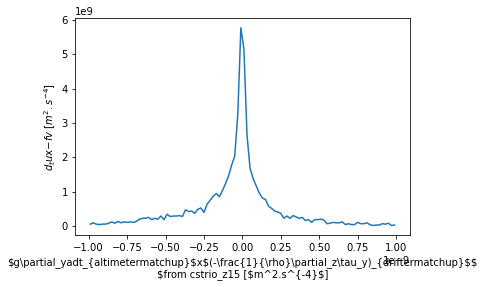

In [35]:
ds_pdf.pdf_cro_acccoriolis_co_es_cstrio_z0_alti_x.plot()

## Compute variance, mean, std

In [45]:
def ds_mean_var_std(ds_pdf, bin_dim_acc='acc_bin', bin_dim_cro='crossacc_bin', mean = False, rms=False, var=False, std=True, ms=True):
    """ Return dataset containing mean, variance, rms and std for all pdfs in the given dataset
    
    Parameters
    ----------
    ds_pdf : xarray Dataset
        dataset containing pdfs built by diags
    bin_dim : str
        bin dimension name
    """
    
    list_pdf_name = [l.replace('pdf','') for l in list(ds_pdf.keys()) if 'pdf' in l and 'cro_' not in l]
    list_pdf_name_cro= [l.replace('pdf','') for l in list(ds_pdf.keys()) if 'pdf' in l and 'cro_' in l]
    _ds=xr.Dataset()
    
    for name in list_pdf_name :
        bin_dim=bin_dim_acc
        rescale=ds_pdf['pdf'+name].integrate(coord=bin_dim)
        
        _ds['mean' + name] = ((ds_pdf[bin_dim]*ds_pdf['pdf' + name])
                              .integrate(coord=bin_dim)/rescale).assign_attrs({** ds_pdf['pdf' + name].attrs,
                                                                               'description':ds_pdf['pdf' +name].attrs['description'].replace('independant pdf of ','mean of '),
                                                                               #'long_name':r'$\langle$'+ds_pdf['pdf' +name].attrs['long_name'].split('[')[1].replace(']','')+r'$\rangle$',
                                                                               'long_name':r'$\langle$'+ds_pdf['pdf' +name].attrs['long_name'].replace('[','').replace(']','')+r'$\rangle$',
                                                                               'units':r'$m.s^{-2}$',
                                                                              })
        
        _ds['var' + name] = (((ds_pdf[bin_dim]-_ds['mean' + name])**2*ds_pdf['pdf' + name]
                                 ).integrate(coord = bin_dim)/rescale).assign_attrs({** ds_pdf['pdf' + name].attrs,
                                                                                   'description':ds_pdf['pdf' +name].attrs['description'].replace('independant pdf of ','variance of '),
                                                                                   'long_name':ds_pdf['pdf' +name].attrs['long_name'].replace('pdf','var'),
                                                                                    'units':r'$m^2.s^{-4}$',
                                                                                    })
        
                                 
        _ds['std' + name]=np.sqrt(_ds['var' + name]).assign_attrs({** ds_pdf['pdf' + name].attrs,
                                                                   'description':ds_pdf['pdf' +name].attrs['description'].replace('independant pdf of ','standard deviation of '),
                                                                   'long_name':ds_pdf['pdf' +name].attrs['long_name'].replace('pdf',r'$\sigma$'),
                                                                   'units':r'$m.s^{-2}$',
                                                                  })
        
        _ds['rms' + name]=np.sqrt((np.square(ds_pdf[bin_dim])*ds_pdf['pdf' + name]).integrate(coord=bin_dim)/rescale).assign_attrs({** ds_pdf['pdf' + name].attrs,
                                                                               'description':ds_pdf['pdf' +name].attrs['description'].replace('independant pdf of ','root mean square of '),
                                                                               'long_name':ds_pdf['pdf' +name].attrs['long_name'].replace('pdf','rms'),
                                                                                                                                   'units':r'$m^2.s^{-4}$',
                                                                                                                                   })
        
        _ds['ms' + name]=((np.square(ds_pdf[bin_dim])*ds_pdf['pdf' + name]).integrate(coord=bin_dim)/rescale).assign_attrs({** ds_pdf['pdf' + name].attrs,
                                                                               'description':ds_pdf['pdf' +name].attrs['description'].replace('independant pdf of ','mean square of '),
                                                                               'long_name':ds_pdf['pdf' +name].attrs['long_name'].replace('pdf','ms'),
                                                                                                                                   'units':r'$m.s^{-2}$',
                                                                                                                                   })
    if list_pdf_name_cro != []:#cross products terms mean = correlation
        for name in list_pdf_name_cro:
            bin_dim=bin_dim_cro
            _ds['mean' + name]=((np.square(ds_pdf[bin_dim])*ds_pdf['pdf' + name]).integrate(coord=bin_dim)/rescale).assign_attrs({** ds_pdf['pdf' + name].attrs,
                                                                               'description':ds_pdf['pdf' +name].attrs['description'].replace('independant pdf of ','mean of '),
                                                                               'long_name':ds_pdf['pdf' +name].attrs['long_name'].replace('pdf','mean'),
                                                                                                                                   'units':r'$m^2.s^{-4}$',
                                                                                                                                   })


        
    if not mean : _ds = _ds.drop([v for v in _ds.keys() if 'mean' in v])
    if not var : _ds = _ds.drop([v for v in _ds.keys() if 'var' in v])
    if not std : _ds = _ds.drop([v for v in _ds.keys() if 'std' in v])
    if not rms : _ds = _ds.drop([v for v in _ds.keys() if 'rms' in v])
    if not ms : _ds = _ds.drop([v for v in _ds.keys() if 'ms' in v])
    
    if 'id_comb' in ds_pdf :
        _ds['id_comb']= ds_pdf['id_comb'] 
        
    if 'nb_coloc_bins' in ds_pdf :
        _ds['nb_coloc_bins']= ds_pdf['nb_coloc_bins'] 

    return _ds



In [46]:
ds_stat = ds_mean_var_std(ds_pdf)
ds_stat

<xarray.Dataset>
Dimensions:                              (id_comb: 72)
Coordinates:
  * id_comb                              (id_comb) <U44 'co_es_cstrio_z0_alti...
Data variables: (12/66)
    std_alti_g_grad_x                    float64 3.356e-05
    ms_alti_g_grad_x                     float64 1.126e-09
    std_alti_denoised_g_grad_x           float64 1.635e-05
    ms_alti_denoised_g_grad_x            float64 2.674e-10
    std_drifter_acc_x                    float64 1.9e-05
    ms_drifter_acc_x                     float64 3.667e-10
    ...                                   ...
    std_e5_cstrio_z15_alti_wd_y          float64 4.001e-06
    ms_e5_cstrio_z15_alti_wd_y           float64 1.602e-11
    std_e5_cstrio_z15_drifter_wd_x       float64 4.286e-06
    ms_e5_cstrio_z15_drifter_wd_x        float64 1.852e-11
    std_e5_cstrio_z15_drifter_wd_y       float64 4.283e-06
    ms_e5_cstrio_z15_drifter_wd_y        float64 1.836e-11

In [76]:
ds_std_ind

<xarray.Dataset>
Dimensions:                         (alti___distance_bin: 49,
                                     alti___time_difference_bin: 49, id_comb: 32)
Coordinates:
  * alti___distance_bin             (alti___distance_bin) float64 1e+03 ... 9...
  * alti___time_difference_bin      (alti___time_difference_bin) float64 100....
  * id_comb                         (id_comb) <U35 'co_es_cstrio_z0_alti_x' ....
Data variables: (12/26)
    std_g_grad_x                    (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_denoised_g_grad_x           (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_acc_x                       (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_acc_y                       (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_coriolis_x                  (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_coriolis_y                  (alti___distance_bin, alti___time_difference_bin) float64 ...
    ...                              ...
    std_es_cstrio_z15_drifter_wd_x  (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_es_cstrio_z15_drifter_wd_y  (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_e5_cstrio_z15_alti_wd_x     (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_e5_cstrio_z15_alti_wd_y     (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_e5_cstrio_z15_drifter_wd_x  (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_e5_cstrio_z15_drifter_wd_y  (alti___distance_bin, alti___time_difference_bin) float64 ...

In [79]:
ds_std_sum

<xarray.Dataset>
Dimensions:                                      (alti___distance_bin: 49,
                                                  alti___time_difference_bin: 49,
                                                  id_comb: 32)
Coordinates:
  * alti___distance_bin                          (alti___distance_bin) float64 ...
  * alti___time_difference_bin                   (alti___time_difference_bin) float64 ...
  * id_comb                                      (id_comb) <U35 'co_es_cstrio...
Data variables: (12/32)
    std_sum_co_es_cstrio_z0_alti_x               (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_sum_co_es_cstrio_z0_drifter_x            (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_sum_co_e5_cstrio_z0_alti_x               (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_sum_co_e5_cstrio_z0_drifter_x            (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_sum_co_es_cstrio_z15_alti_x              (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_sum_co_es_cstrio_z15_drifter_x           (alti___distance_bin, alti___time_difference_bin) float64 ...
    ...                                           ...
    std_sum_aviso_es_cstrio_z15_alti_y           (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_sum_aviso_e5_cstrio_z15_alti_y           (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_sum_aviso_es_cstrio_z0_drifter_y         (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_sum_aviso_e5_cstrio_z0_drifter_y         (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_sum_aviso_es_cstrio_z15_drifter_y        (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_sum_aviso_e5_cstrio_z15_drifter_y        (alti___distance_bin, alti___time_difference_bin) float64 ...

In [80]:
ds_std

<xarray.Dataset>
Dimensions:                                               (
                                                           alti___distance_bin: 49,
                                                           alti___time_difference_bin: 49,
                                                           id_comb: 32)
Coordinates:
  * alti___distance_bin                                   (alti___distance_bin) float64 ...
  * alti___time_difference_bin                            (alti___time_difference_bin) float64 ...
  * id_comb                                               (id_comb) <U35 'co_...
Data variables: (12/186)
    std_g_grad_x                                          (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_denoised_g_grad_x                                 (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_acc_x                                             (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_acc_y                                             (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_coriolis_x                                        (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_coriolis_y                                        (alti___distance_bin, alti___time_difference_bin) float64 ...
    ...                                                    ...
    std_exc_ggrad_aviso_es_cstrio_z15_drifter_y           (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_exc_wind_aviso_es_cstrio_z15_drifter_y            (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_exc_acc_aviso_e5_cstrio_z15_drifter_y             (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_exc_coriolis_aviso_e5_cstrio_z15_drifter_y        (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_exc_ggrad_aviso_e5_cstrio_z15_drifter_y           (alti___distance_bin, alti___time_difference_bin) float64 ...
    std_exc_wind_aviso_e5_cstrio_z15_drifter_y            (alti___distance_bin, alti___time_difference_bin) float64 ...

In [ ]:
cluster.close()